In [1]:
%matplotlib inline

from datetime import datetime as dt
from itertools import combinations, product
from math import asin, sqrt

import numpy
import pennylane as qml
from pennylane import numpy as np
from scipy.optimize import minimize
from scipy.special import comb

import matplotlib.pyplot as plt

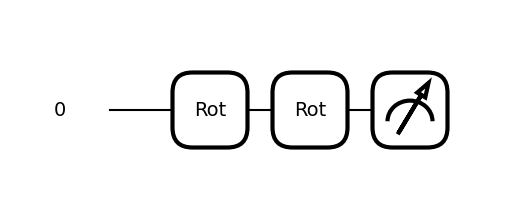

In [3]:
# basic circuit in pennylane

dev = qml.device("default.qubit", wires=1)

@qml.qnode(dev, interface="autograd")
def qcircuit(params,y):

    for p in params:
        qml.Rot(*p, wires=0)
    return qml.expval(qml.Hermitian(y, wires=[0]))

def density_matrix(state):
    return state * np.conj(state).T

Y = density_matrix([[1], [0]])

params = np.random.uniform(size=(2, 3))

qml.draw_mpl(qcircuit)(params, Y)
plt.show()

In [4]:
class VQA:
    """
    Base class for the VQAs. For an algorithm like QAOA, it has two lists of parameters:
    gammas and betas. `params` is
    a list of each list of parameters and `self.param_shapes` is a list of the numpy
    shape for each list of parameters.
    """

    OPTIMIZERS = {
        "grad_descent": qml.GradientDescentOptimizer,
        "adagrad": qml.AdagradOptimizer,
        "adam": qml.AdamOptimizer,
    }

    def __init__(
        self,
        Jij,
        depth,
        steps=None,
        prec=1e-4,
        optimizer="adam",
        opt_kwargs={},
        device="default.qubit",
        bitflip_prob=0,
    ):
        """
        In the __init__ for inheriting classes:
            1) Define the cost and mixer Hamiltonians using self.edges/self.weights for
            the cost Hamiltonian and self.vertices for the mixer Hamiltonian which are
            used in your definition for `layer`.
            2) Define the array shapes for the lists of parameters as a list defined as
            `self.param_shapes`.
            3) Define the operator to take the expectation value of, i.e. the total
            cost Hamiltonian as `self.expval_op`.

        Parameters:
        Jij - Ising NxN matrix.
        depth - How many layers in the circuit, written as `p`.
        steps - How many steps to run the optimizer.
        prec - How precise the optimizer should be. That is the optimizer won't stop
            until the difference between the latest two evaluations are less that `prec`
            or `steps` number of evaluations have been completed. That is, which ever
            happens first.
        optimizer - Which optimizer to use: "grad_descent", "adagrad" or "adam" for the
            gradient descent, adagrad or adam optimizer.
        opt_kwargs - A dictionary of keyword arguments to pass to the optimizer object.
        device - The pennylane device to run on.
        """
        self._Jij = Jij
        self.max_Jij = np.max(Jij)
        self.Jij = self._Jij / self.max_Jij
        self.depth = depth
        self.steps = steps
        self.prec = prec
        self.N = len(Jij)
        self.bitflip_prob = bitflip_prob

        # If want noisy circuit, force use of "default.mixed" to do so
        self.device = qml.device(device, wires=self.N)
        self.str_opt = optimizer
        self.optimizer = self.OPTIMIZERS[optimizer](**opt_kwargs)

        self.bit_strs = numpy.array(
            ["".join(bs) for bs in product(["0", "1"], repeat=self.N)]
        )
        self.vertices = numpy.arange(self.N)
        self.edges = numpy.array(list(combinations(range(self.N), r=2)))
        self.weights = numpy.array([self.Jij[edge[0], edge[1]] for edge in self.edges])

    def layer(self, *params):
        """
        Each layer of the VQA. Each arg from `params` is a list of parameters, e.g. QAOA
        has two: gammas and betas but XQAOA has three: gammas, betas and alphas.
        """
        pass

    def circuit(self, *params):
        """
        Variational circuit for given parameters.
        """
        # Initialize with Hadamards
        for ind in range(self.N):
            qml.Hadamard(wires=ind)
        qml.Barrier()

        # Add layers
        qml.layer(self.layer, self.depth, *params)

    def _cost_circuit(self, *params):
        """
        Define `self.expval_op` in inheriting class's __init__. It is the total cost
        function, usually problem/cost Hamiltonian.
        """
        self.circuit(*params)
        return qml.expval(self.expval_op)

    def _probs_circuit(self, *params):
        """
        Circuit for getting probabilities for each eigenstate.
        """
        self.circuit(*params)
        return qml.probs()

    def get_probs(self, as_dict=False):
        """
        Gets the probabilities for each eigenstate.
        """
        probs_qnode = qml.QNode(self._probs_circuit, self.device)
        # probs = probs_qnode(*self.params).numpy()
        probs = probs_qnode(*self.params)
        if as_dict:
            return dict(zip(self.bit_strs, probs))
        return probs

    def optimize(self, init_params=None, print_it=False, init_val=0.5):
        """
        Runs the optimization for given initial parameters. The shapes of those
        parameters should defined in a list as `self.param_shapes` in the __init__
        """
        self.params = init_params
        if self.params is None:
            self.params = [init_val * np.ones(shape) for shape in self.param_shapes]

        # Make sure the shapes are correct
        for ind, shape in enumerate(self.param_shapes):
            if self.params[ind].shape != shape:
                raise TypeError(
                    f"Index {ind} of keyword `init_params` should be of shape "
                    + f"{shape}, not {self.params[ind]}"
                )

        if self.bitflip_prob != 0:
            noisy_device = qml.transforms.insert(
                self.device, op=qml.BitFlip, op_args=self.bitflip_prob
            )
            self.cost_qnode = qml.QNode(func=self._cost_circuit, device=noisy_device)
        else:
            # Create QNode (a la the decorator way)
            self.cost_qnode = qml.QNode(func=self._cost_circuit, device=self.device)

        # Run through the steps of the optimizing
        if print_it:
            print("Start:\n")
        self.costs = np.empty(self.steps)
        self.evals = self.steps
        start = dt.now()
        for ind in range(self.steps):
            # Save the value of the cost per step too
            self.params, self.costs[ind] = self.optimizer.step_and_cost(
                self.cost_qnode,
                *self.params,
            )
            # if print_it:
            #     print(
            #         f"[{self.__class__.__name__}] {self.str_opt} > "
            #         + f"Calculating step {ind + 1}/{self.steps}...",
            #         end="\r",
            #         flush=True,
            #     )
            if ind:
                self.current_prec = abs(1 - self.costs[ind - 1] / self.costs[ind])
                if print_it:
                    print(
                        f"[{self.__class__.__name__}] {self.str_opt} > "
                        f"Calculating step {ind + 1}/{self.steps}...",
                        f" Time: {(dt.now() - start).total_seconds():.3f}"
                        f" | Current precision: {self.current_prec:.3e}",
                        end="\r",
                        flush=True,
                    )
                if self.current_prec < self.prec:
                    # Trim off extra part of numpy array
                    self.costs = self.costs[: ind + 1]
                    self.evals = ind + 1
                    break
            else:
                if print_it:
                    print(end="\r", flush=True)
        self.params = [param.numpy() for param in self.params]
        self.costs = self.costs.numpy()
        if print_it:
            print("\nDone!")

In [5]:
class QAOA(VQA):
    def __init__(
        self,
        Jij,
        depth,
        steps,
        prec=1e-6,
        optimizer="grad_descent",
        opt_kwargs={},
        device="default.qubit",
        bitflip_prob=0,
    ):
        super().__init__(
            Jij=Jij,
            depth=depth,
            steps=steps,
            prec=prec,
            optimizer=optimizer,
            opt_kwargs=opt_kwargs,
            device=device,
            bitflip_prob=bitflip_prob,
        )

        self.param_shapes = ((self.depth,), (self.depth,))

        # Expectation value operator: problem Hamiltonian
        self.expval_op = qml.Hamiltonian(
            self.weights,
            [qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1]) for edge in self.edges],
        )

    def layer(self, gamma, beta):
        # Create Pauli rotation gates
        for edge, weight in zip(self.edges, self.weights):
            qml.PauliRot(gamma * weight, "ZZ", wires=edge)
        qml.Barrier()
        for ind in range(self.N):
            qml.PauliRot(beta, "X", wires=ind)
        qml.Barrier()

In [6]:
class MAQAOA(VQA):
    """
    Instead of a free parameter per layer for the cost Hamiltonian and the mixer
    Hamiltonian, each gate has its own free parameter. So for a depth of `p` and N
    qubits, there are (NChoose2 + N)p free parameters (instead of just 2p).
    See: https://www.nature.com/articles/s41598-022-10555-8
    """

    def __init__(
        self,
        Jij,
        depth,
        steps,
        prec=1e-6,
        optimizer="grad_descent",
        opt_kwargs={},
        device="default.qubit",
        bitflip_prob=0,
    ):
        super().__init__(
            Jij=Jij,
            depth=depth,
            steps=steps,
            prec=prec,
            optimizer=optimizer,
            opt_kwargs=opt_kwargs,
            device=device,
            bitflip_prob=bitflip_prob,
        )
        # comb(N, 2) == N choose 2 edges between N vertices in maximally connected graph
        self.param_shapes = ((self.depth, int(comb(self.N, 2))), (self.depth, self.N))

        # Expectation value operator: problem Hamiltonian
        self.expval_op = np.sum(
            [
                qml.Hamiltonian([weight], [qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1])])
                for weight, edge in zip(self.weights, self.edges)
            ]
        )

    def layer(self, gammas, betas):
        # Each gate gets its own beta/gamma parameter
        for edge, weight, gamma in zip(self.edges, self.weights, gammas):
            qml.PauliRot(gamma * weight, "ZZ", wires=edge)
        qml.Barrier()
        for ind, beta in zip(range(self.N), betas):
            qml.PauliRot(beta, "X", wires=ind)
        qml.Barrier()

In [7]:
class FALQON:
    """
    Feedback-based ALgorithm for Quantum OptimizatioN (FALQON) builds its circuit
    iteratively by calculating the per-layer parameter via the expectation value
    of i[Hm, Hc] thus removing the need for optimization/backpropagation.
    See: 2103.08619.

    Since the parameters are fixed once found, this class calculates the state for
    layer n, then initializes the the next layer with that state so the (n+1)th layer
    only needs to run a circuit of 1 layer deep.
    """

    def __init__(self, Jij, depth, dt=0.08, init_beta=0, device="default.qubit"):
        self._Jij = Jij
        self.max_Jij = np.max(Jij)
        # Keep the quadratic coefficient normalized
        self.Jij = self._Jij / self.max_Jij
        self.depth = depth
        # Number of final state particles in problem
        self.N = len(Jij)

        self.device = qml.device(device, wires=self.N)

        # Stuff for weighting gates
        self.bit_strs = numpy.array(
            ["".join(bs) for bs in product(["0", "1"], repeat=self.N)]
        )
        self.vertices = numpy.arange(self.N)
        self.edges = numpy.array(list(combinations(range(self.N), r=2)))
        self.weights = numpy.array([self.Jij[edge[0], edge[1]] for edge in self.edges])

        # FALQON-specific parameters
        self.dt = dt
        self.init_beta = init_beta

        # List of parameters
        self.betas = []
        # List of probabilities per depth
        self.depth_probs = []
        # Temporarily stores the newest parameter
        self._new_beta = init_beta
        # Intial state to equal superposition (Hadamards on all qubits)
        self._cur_state = sqrt(1 / 2**self.N) * np.ones(2**self.N)

        # Commutator i[Hc, Hm] whose expval gives parameter of next layer
        comm_gates, comm_weights = [], []
        for i in range(self.N):
            for j, k in combinations(range(self.N), r=2):
                # [Xi, wjk*ZjZk] = -2iwjk(δijYiZk + δikZjYi)
                # delta_ij
                if i == j:
                    comm_weights.append(2 * self.Jij[j, k])
                    comm_gates.append(qml.PauliY(i) @ qml.PauliZ(k))
                # delta_jk
                elif i == k:
                    comm_weights.append(2 * self.Jij[j, k])
                    comm_gates.append(qml.PauliZ(j) @ qml.PauliY(i))
        self.commutator = qml.Hamiltonian(comm_weights, comm_gates)

        # Expectation value: problem Hamiltonian
        self.expval_op = qml.Hamiltonian(
            self.dt * self.weights,
            [qml.PauliZ(edge[0]) @ qml.PauliZ(edge[1]) for edge in self.edges],
        )

    def _state_circuit(self):
        """
        Finds the output state of the current circuit. Saved in `self._cur_state` and
        used to initalize the next layer.
        """
        self.circuit(self._new_beta)
        return qml.state()

    def _probs_circuit(self):
        """
        Circuit to return the probabilities for each eigenstate.
        """
        self.circuit()
        return qml.probs()

    def _param_circuit(self):
        """
        Circuit to both minimize the cost function (i.e. the expectation value of
        `self.expval_op` with respect to the circuit) and the next parameter value.
        """
        self.circuit(self._new_beta)
        return qml.expval(self.expval_op), qml.expval(self.commutator)

    def circuit(self, beta=None):
        """
        Actual circuit to run.
        """
        # For an n layer circuit, initialize the first n-1 layers
        qml.QubitStateVector(self._cur_state, wires=range(self.N))

        # If you just want to run the circuit as is (without adding another layer)
        if beta is not None:
            # Then add the nth layer
            for edge, weight in zip(self.edges, self.weights):
                qml.PauliRot(self.dt * weight, "ZZ", wires=edge)
            for ind in range(self.N):
                qml.PauliRot(self.dt * beta, "X", wires=ind)

    def get_probs(self, as_dict=False):
        """
        Gets the probabilities for each eigenstate.
        """
        probs_qnode = qml.QNode(self._probs_circuit, self.device)
        # probs = probs_qnode().numpy()
        probs = probs_qnode()
        if as_dict:
            return dict(zip(self.bit_strs, probs))
        return probs

    def run(self, print_it=False):
        """`
        Run the FALQON algorithm
        """
        # For other algorithms, they stop when cost function stops decreasing at a rate
        # below some threshold. We don't have that here, so there will a number of
        # evaluations equal to the depth of the circuit
        self.evals = self.depth
        self.costs = numpy.empty(self.depth)

        for ind in range(self.depth):
            if print_it:
                print(
                    f"[FALQON] > Calculating depth {ind + 1}/{self.depth}...",
                    end="\r",
                )

            # Save value of parameter
            self.betas.append(self._new_beta)
            # Get the current cost and new parameter values
            param_qnode = qml.QNode(self._param_circuit, self.device)
            cost, beta = param_qnode()
            # Get the current state of circuit
            state_qnode = qml.QNode(self._state_circuit, self.device)

            self.costs[ind] = cost
            # Save the probabilities for each depth
            self.depth_probs.append(self.get_probs(True))
            # Save state and parameter for next layer
            self._cur_state = state_qnode()
            self._new_beta = -beta.numpy()

        self.betas = numpy.array(self.betas)
        # To put in same format as with the parameters for other algorithms
        self.params = [self.betas]

        if print_it:
            print("\Done!")

In [8]:
def calc_Jij(p4):
    """
    Jij - Ising NxN matrix created from 4-momenta defined in 2111.07806.

    Parameters:
    p4 - The 4-momenta of the particles. A Nx4 array.

    Returns (
        NxN Jij weight matrix
    )
    """
    METRIC = np.array([1, -1, -1, -1])
    
    N = p4.shape[0]
    
    Pij_iter = np.array(list(product(range(N), repeat=2)))
    Jij_iter = np.array(list(product(range(N), repeat=4)))
    
    Pij = np.zeros((N, N))
    for i, j in Pij_iter:
        Pij[i, j] = np.dot(METRIC * p4[i], p4[j])

    Jij = np.zeros((N, N))
    for i, j, k, l in Jij_iter:
        Jij[i, j] += Pij[i, k] * Pij[j, l]

    return Jij

In [9]:
def plot_bars(ax: plt.Axes, probs: dict[str, float],**kwargs) -> plt.Axes.bar:
    values = list(probs.values())
    labels = list(probs.keys())
    
    values, labels = zip(*sorted(zip(values, labels), key=lambda x: x[0], reverse=True))
    bar = ax.bar(x = labels[:32], height =  values[:32])
    
    ax.set_ylabel(kwargs.get("ylabel", ""), fontsize=kwargs.get("ylabel_fs", 13))
    ax.set_xlabel(kwargs.get("xlabel", ""), fontsize=kwargs.get("xlabel_fs", 13))
    ax.set_title(kwargs.get("title", ""), fontsize=kwargs.get("title_fs", 18))
    ax.tick_params(axis="x", rotation=kwargs.get("x_rot", 45))

    return bar

In [10]:
# Data = np.load('Hadronic_events_momentum.npz')
Data = np.array([[ 253.7314301 ,   44.04090566,  -24.93994717,  248.58790454],
        [ 227.29699371,  -52.74772424, -100.72257556,  196.81606568],
        [  96.05325035,   30.30357229,  -51.19953142,   75.40907366],
        [ 200.11834073,    7.47624708,   68.30675951, -187.89239642],
        [  92.96820691,  -34.14446203,   48.52513268,  -71.57202462],
        [  60.59631039,    5.07146124,   60.03016196,    6.52478115]])

In [13]:
Jij = calc_Jij(Data)

Top_QAOA = QAOA(Jij = Jij, depth = 2, steps = 100, optimizer="adam")
Top_QAOA.optimize(print_it=True)

Start:

[QAOA] adam > Calculating step 100/100...  Time: 8.256 | Current precision: 5.766e-02
Done!


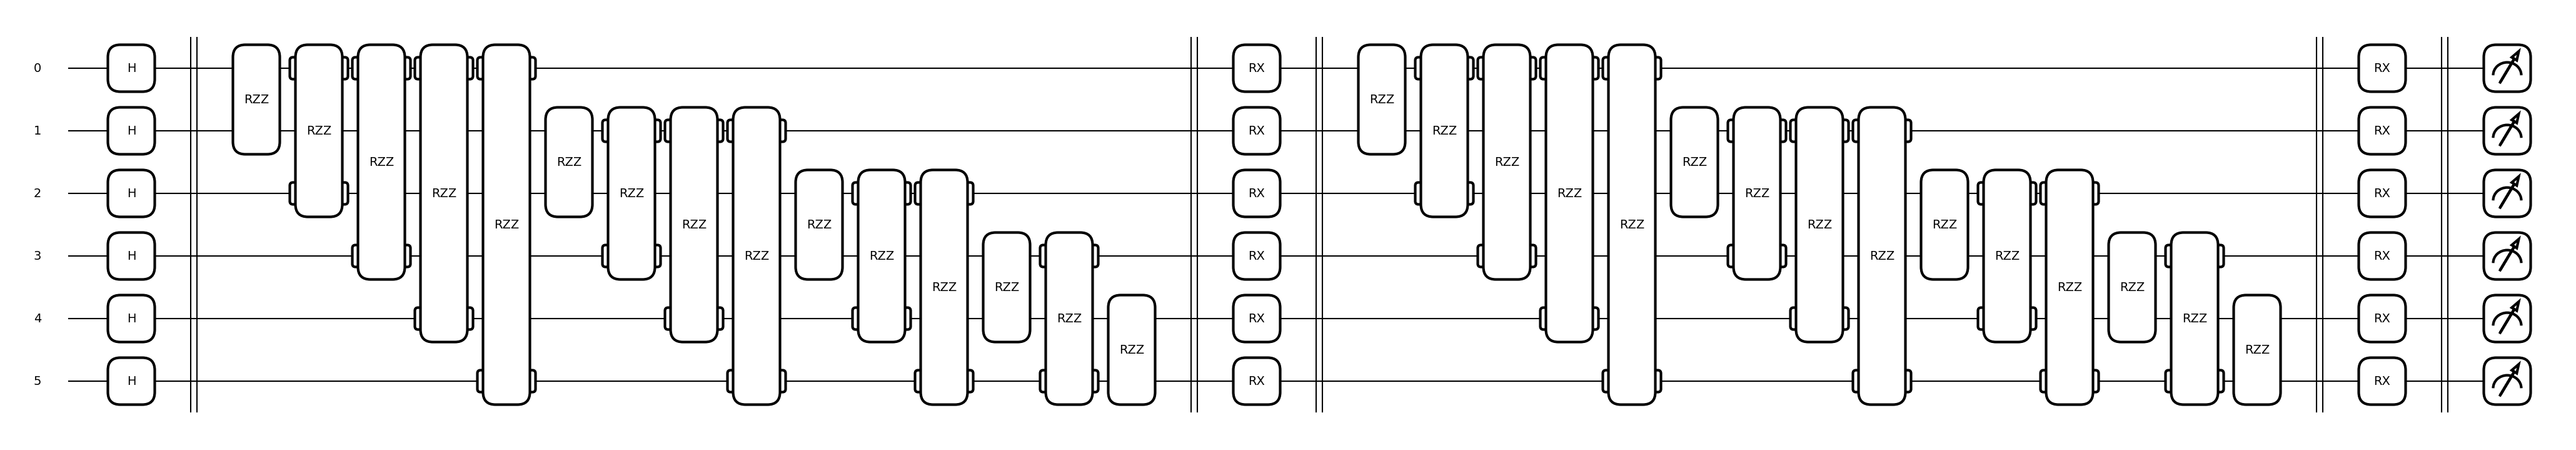

In [14]:
qml.draw_mpl(Top_QAOA._cost_circuit)(*Top_QAOA.params)

plt.show()

In [16]:
Top_QAOA = QAOA(Jij = Jij, depth = 5, steps = 1000, optimizer="adam")

In [17]:
Top_QAOA.optimize(print_it=True)

Start:

[QAOA] adam > Calculating step 1000/1000...  Time: 173.723 | Current precision: 7.581e-05
Done!


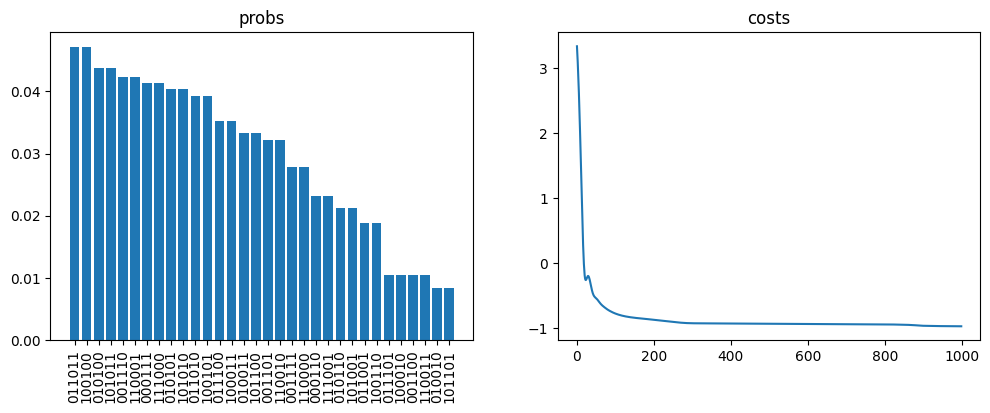

In [18]:
QAOA_probs = Top_QAOA.get_probs(as_dict=True)
fig, ax = plt.subplots(1, 2,figsize=(12, 4))

plot_bars(ax = ax[0], probs = QAOA_probs, x_rot = 90)
ax[0].set_title('probs')

ax[1].plot(Top_QAOA.costs)
ax[1].set_title('costs')


plt.show()

In [19]:
Top_MAQAOA = MAQAOA(Jij = Jij, depth = 5, steps = 1000, optimizer="adam")
Top_MAQAOA.optimize(print_it=True)
print(Top_MAQAOA.get_probs().argmax())

Start:

[MAQAOA] adam > Calculating step 1000/1000...  Time: 180.447 | Current precision: 2.090e-06
Done!
7


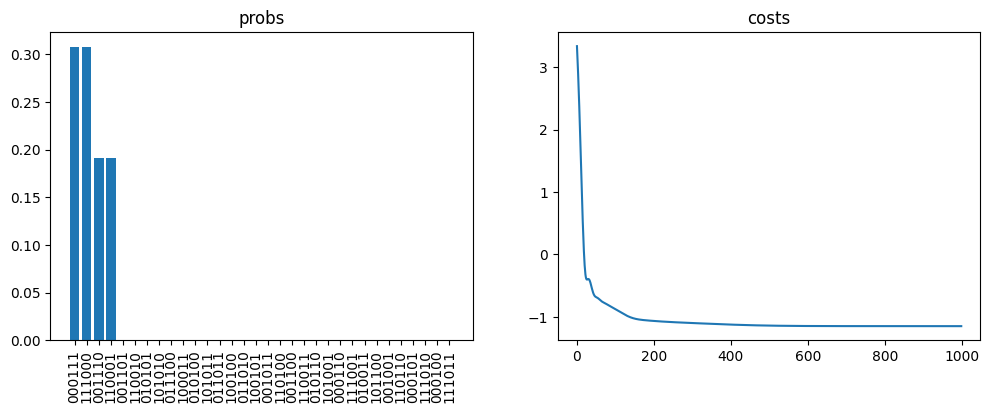

In [20]:
MAQAOA_probs = Top_MAQAOA.get_probs(as_dict=True)
fig, ax = plt.subplots(1, 2,figsize=(12, 4))

plot_bars(ax = ax[0], probs = MAQAOA_probs, x_rot = 90)
ax[0].set_title('probs')

ax[1].plot(Top_MAQAOA.costs)
ax[1].set_title('costs')


plt.show()

In [21]:
TOP_FALQON = FALQON(Jij = Jij, depth = 500)
TOP_FALQON.run(print_it=True)

\Done!N] > Calculating depth 500/500...


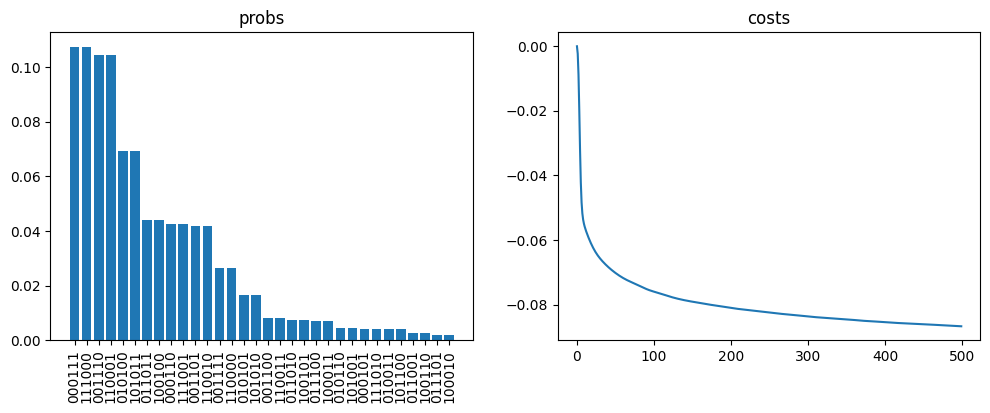

In [22]:
FALQON_probs = TOP_FALQON.get_probs(as_dict=True)
fig, ax = plt.subplots(1, 2,figsize=(12, 4))

plot_bars(ax = ax[0], probs = FALQON_probs, x_rot = 90)
ax[0].set_title('probs')

ax[1].plot(TOP_FALQON.costs)
ax[1].set_title('costs')


plt.show()